# The Capture24 dataset

<img src="wrist_accelerometer.jpg" width="300"/>

The Capture24 dataset consists of wrist-worn accelerometer measurements collected from about 150 participants that wore the device for 24 hours.
Along with the accelerometer, the participants also wore a body camera that recorded their daily activities. Trained human annotators then assigned an activity label to every 30 seconds of accelerometer recording based on the camera information. The identified activities are *sleep*, *sedentary*, *tasks-light*, *walking* and *moderate*.

The two main files we will work with are `X_raw.dat` and `capture24.npz`. The
first contains the raw accelerometer measurements and the latter is a bundle
of numpy arrays including, among other things, hand-crafted features extracted from the raw measurements and corresponding activity labels.

###### Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import manifold
import utils  # contains helper functions for this workshop -- check utils.py

# For reproducibility
np.random.seed(42)

# A useful plotting function
def my_scatter_plot(X, y):
    fig, ax = plt.subplots()
    for i in range(utils.NUM_CLASSES):
        ax.scatter(X[y==i, 0], X[y==i, 1],
            c=utils.COLORS[i], label=utils.CLASSES[i], alpha=0.25, s=10)
    fig.legend()
    return fig, ax

###### Load the dataset files 

In [2]:
data = np.load('capture24.npz', allow_pickle=True)
print("Contents of capture24.npz:", data.files)
X_feats, y, pid, time, annotation = \
    data['X_feats'], data['y'], data['pid'], data['time'], data['annotation']
print('X_feats shape:', X_feats.shape)
print('y shape:', y.shape)
print('pid shape:', pid.shape)
print('time shape:', time.shape)
print('annotation shape:', annotation.shape)
X_raw = np.load('X_raw.npy', mmap_mode='r')
print('X_raw shape:', X_raw.shape)

Contents of capture24.npz: ['X_feats', 'y', 'pid', 'time', 'annotation']
X_feats shape: (330610, 125)
y shape: (330610,)
pid shape: (330610,)
time shape: (330610,)
annotation shape: (330610,)
X_raw shape: (330610, 3, 3000)


###### Description of the arrays

- `X_raw` numpy array of shape `(N,3,3000)` where each row corresponds to 30 seconds of raw tri-axial measurement at 100Hz.

- `X_feats` numpy array of shape `(N,125)` where each row corresponds to *hand-crafted features* extracted from raw 30 seconds measurements. This is a collection of features used in published literature such as mean acceleration, covariances between axes, Fourier coefficients, estimated angles, etc. For details, see *References* at the bottom, also `java_feature_extractor/FeatureExtractor.java` for the feature extractor code.

- `y` numpy array of shape `(N,)` indicating the activity (0: sleep, 1: sedentary, 2: tasks-light, 3: walking, 4: moderate) performed during the 30 seconds instance.

- `time` numpy array of shape `(N,)` indicating the start time of the corresponding measurement.

- `pid` numpy array of shape `(N,)` indicating the participant ID for the corresponding instance.

- `annotation` numpy array of shape `(N,)` containing fine-grained descriptions of the activity performed in the corresponding instance.

Arrays `X_feats`, `y`, `time`, `pid` and `annotation` are stored in a single `capture24.npz` file, while `X_raw` is stored separately in `X_raw.npy` due to its large size (~11GB).

**Note:**
The provided arrays `X_feats`, `X_raw`, `y`, etc. are so that consecutive
rows correspond to continuous measurements in time for a same participant.
Discontinuities will naturally occur at the edges between two participants, which can be inferred from the `pid` array.
Interrupts in the measurement within a same participant may also occur
(e.g. device run out of battery), and can be inferred from `time` array.

# Visualization
Visualizing the dataset is an important part of data science. This can
provide useful insights about the problem at hand.

Let's visualize one instance of raw acceleration for each activity:

/cdthome/zhi722/.conda/envs/capture24/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


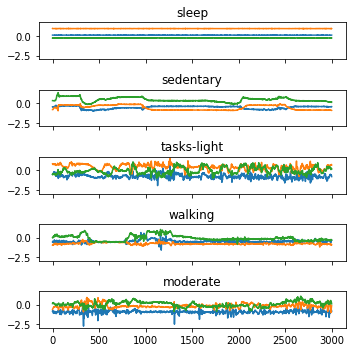

In [3]:
fig, axs = plt.subplots(5, sharex=True, sharey=True, figsize=(5,5))
for i in range(utils.NUM_CLASSES):
    idx = np.where(y == i)[0]
    axs[i].plot(X_raw[idx][0].T)
    axs[i].set_title(utils.CLASSES[i])
fig.tight_layout()
fig.show()

After visualizing individual instances, the next step is to visualize
our dataset as a whole to have a grasp of the data distribution. A
standard visualization approach is to scatter-plot the two principal
components of our dataset.
For performance, let us perform the visualization on a small subset of our
data since our data is rather big:

In [4]:
# grab data from five participants
mask = np.isin(data['pid'], [1, 2, 3, 4, 5])
X_raw = X_raw[mask]
X_feats = X_feats[mask]
y = y[mask]
pid = pid[mask]
time = time[mask]
annotation = annotation[mask]
print('X_feats shape:', X_feats.shape)
print('X_raw shape:', X_raw.shape)

X_feats shape: (11016, 125)
X_raw shape: (11016, 3, 3000)


###### PCA visualization 

Plotting first two PCA components...


/cdthome/zhi722/.conda/envs/capture24/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


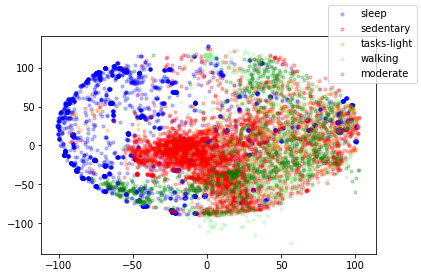

In [5]:
print("Plotting first two PCA components...")
scaler = preprocessing.StandardScaler()  # PCA requires normalized data
X_raw_scaled = scaler.fit_transform(X_raw.reshape(X_raw.shape[0],-1))
pca = decomposition.PCA(n_components=2)  # two components
X_pca = pca.fit_transform(X_raw_scaled)
fig, ax = my_scatter_plot(X_pca, y)
fig.show()

###### t-SNE visualization
The PCA plot is already very informative. What if we want to
visualize more components? A popular high-dimensional data visualization tool
is _t-distributed stochastic neighbor embedding_ (t-SNE). We next use t-SNE to
visualize 128 principal components of our raw dataset:

*Note: this takes a few minutes*

Plotting t-SNE on PCA components...


/cdthome/zhi722/.conda/envs/capture24/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


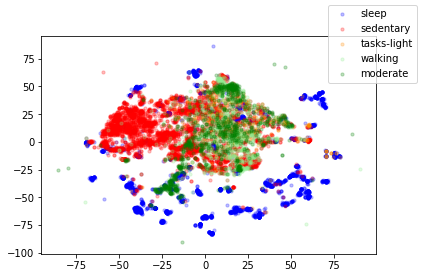

In [9]:
print("Plotting t-SNE on PCA components...")
pca = decomposition.PCA(n_components=128)  # 128 components
X_pca = pca.fit_transform(X_raw_scaled)
tsne = manifold.TSNE(n_components=2,  # project down to 2 components
    init='random', random_state=42, perplexity=50)
X_tsne_pca = tsne.fit_transform(X_pca)
fig, ax = my_scatter_plot(X_tsne_pca, y)
fig.show()

###### t-SNE on `X_feats`

Finally, let's perform a t-SNE visualization this time on the
hand-crafted features `X_feats`:

*Note: this takes a few minutes*

Plotting t-SNE on hand-crafted features...


/cdthome/zhi722/.conda/envs/capture24/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


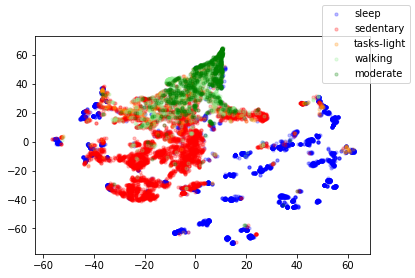

In [13]:
print("Plotting t-SNE on hand-crafted features...")
tsne = manifold.TSNE(n_components=2,
    init='random', random_state=42, perplexity=120)
X_tsne_feats = tsne.fit_transform(X_feats)
fig, ax = my_scatter_plot(X_tsne_feats, y)
fig.show()

Our preliminary plots seem to suggest that classifying "sleep" and
"sedentary" activities may be easy while classifying "tasks-light", "walking"
and "moderate" activities may be more challenging.

###### Ideas

- Tune the `perplexity` parameter of t-SNE to see how it affects the plots.
- Our dataset is highly unbalanced:

In [14]:
print(np.unique(y, return_counts=True))

(array([0, 1, 2, 3, 4]), array([4160, 4644,  372,  887,  953]))


In [16]:
def balanced_subsample(x,y,subsample_size=1.0):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            np.random.shuffle(this_xs)

        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.append(x_)
        ys.append(y_)

    xs = np.concatenate(xs)
    ys = np.concatenate(ys)

    return xs,ys

In [18]:
X_feats_s , y_s = balanced_subsample(X_feats, y)

In [20]:
print(np.unique(y_s, return_counts=True))

(array([0., 1., 2., 3., 4.]), array([372, 372, 372, 372, 372]))


Plotting t-SNE on hand-crafted features...


/cdthome/zhi722/.conda/envs/capture24/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


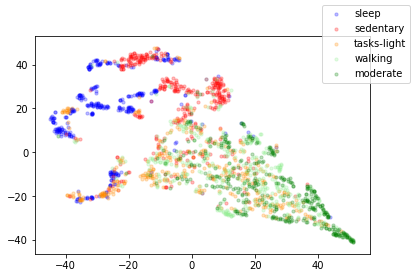

In [26]:

print("Plotting t-SNE on hand-crafted features...")
tsne = manifold.TSNE(n_components=2,
    init='random', random_state=42, perplexity=40)
X_tsne_feats = tsne.fit_transform(X_feats_s)
fig, ax = my_scatter_plot(X_tsne_feats, y_s)
fig.show()

As seen, there is barely any "tasks-light" activities. To aid the
visualization, try balancing the activities to be scatter-plotted.

###### References
- Source of the hand-crafted features:
    - [Physical activity classification using the GENEA wrist-worn accelerometer](https://www.ncbi.nlm.nih.gov/pubmed/21988935)
    - [A universal, accurate intensity-based classification of different physical activities using raw data of accelerometer](https://www.ncbi.nlm.nih.gov/pubmed/24393233)
    - [Activity recognition using a single accelerometer placed at the wrist or ankle](https://www.ncbi.nlm.nih.gov/pubmed/23604069)
    - [Hip and Wrist Accelerometer Algorithms for Free-Living Behavior Classification](https://www.ncbi.nlm.nih.gov/pubmed/26673126)